In [1]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [2]:
from firedrake import *
from firedrake.adjoint import *

In [3]:
# NBVAL_IGNORE_OUTPUT
from firedrake.pyplot import tripcolor

def plot_fn(u):
    fig, axes = plt.subplots()
    collection = tripcolor(u, axes=axes)
    fig.colorbar(collection);

In [8]:
from netgen.geom2d import SplineGeometry

def refined_mesh(refinements=0):
    geo = SplineGeometry()
    geo.AddRectangle(p1=(-1, -1),
                     p2=(1, 1),
                     bc="rectangle",
                     leftdomain=1,
                     rightdomain=0)

    mesh = Mesh(geo.GenerateMesh(maxh=0.1))

    def mark_centre(mesh):
        # Used to refine the center of mesh
        W = FunctionSpace(mesh, "DG", 0)
        mark = Function(W)
        x, y = SpatialCoordinate(mesh)
        centre = conditional( And((abs(x) < 0.4) , (abs(y) < 0.4)), 1.0, 0.0 )
        mark.interpolate(centre)
        return mark

    for i in range(refinements):
        mesh = mesh.refine_marked_elements(mark_centre(mesh))
    return mesh                                           

In [9]:
def solve_poisson(m):
    mesh = m.function_space().mesh()
    fs = FunctionSpace(mesh, "CG", 1)
    u = Function(fs)
    v = TestFunction(fs)
    bc = DirichletBC(fs, 0.0, "on_boundary")
    problem = NonlinearVariationalProblem(inner(grad(u), grad(v))*dx - m*v*dx, u, bc)
    solver = NonlinearVariationalSolver(problem)
    solver.solve()
    return u
    

In [24]:
def target(fs):
    x, y = SpatialCoordinate(fs.mesh())
    return assemble(interpolate(sin(pi*x)*sin(pi*y)/(2*pi), fs))


def record_poisson_functional(refinements=0, riesz_map="L2"):
    mesh = refined_mesh(refinements)
    fs = FunctionSpace(mesh, "CG", 1)
    m = Function(fs)  # Use a zero initial guess for the functional.
    tape = get_working_tape()
    tape.clear_tape()

    alpha = 1.e-6  # Control penalty.
    d = target(fs)
    continue_annotation()
    u = solve_poisson(m)
    J = assemble((u - d)**2/2*dx + alpha/2*m**2*dx) 
    pause_annotation()
    return ReducedFunctional(J, Control(m, riesz_map=riesz_map))

In [58]:
Jhat = record_poisson_functional(3, "L2")


In [59]:
m_ = Function(Jhat.controls[0].control)
h = Function(m_)
h.interpolate(1.0)
taylor_test(Jhat, m_, h)

Running Taylor test
Computed residuals: [5.41606632401119e-06, 1.354016580981429e-06, 3.3850414522274687e-07, 8.462603627746796e-08]
Computed convergence rates: [np.float64(2.000000000022768), np.float64(2.0000000000963647), np.float64(2.0000000004810703)]


np.float64(2.000000000022768)

In [60]:
p = MinimizationProblem(Jhat)

In [61]:
from pyadjoint.optimization.tao_solver import TAOSolver

In [62]:
solver = TAOSolver(p, {
    "tao_type": "lmvm",
    #"tao_view": None,
    "tao_monitor": None,
    "tao_converged_reason": None,
    "tao_gatol": 1.0e-5,
    "tao_grtol": 0.0,
    "tao_gttol": 1.0e-5
})

In [63]:
Jhat(m_)
m_new = solver.solve()


  Iteration information for firedrake_2704_ solve.
  0 TAO,  Function value: 0.0124176,  Residual: 0.00790498 
  1 TAO,  Function value: 0.00767434,  Residual: 0.00621374 
  2 TAO,  Function value: 5.45078e-06,  Residual: 0.000192247 
  3 TAO,  Function value: 5.28485e-06,  Residual: 0.000152999 
  4 TAO,  Function value: 4.99822e-06,  Residual: 4.32404e-06 
  TAO firedrake_2704_ solve converged due to CONVERGED_GATOL iterations 4


In [64]:
u = solve_poisson(m_new)
error = assemble(interpolate(u - target(u.function_space()), u.function_space()))

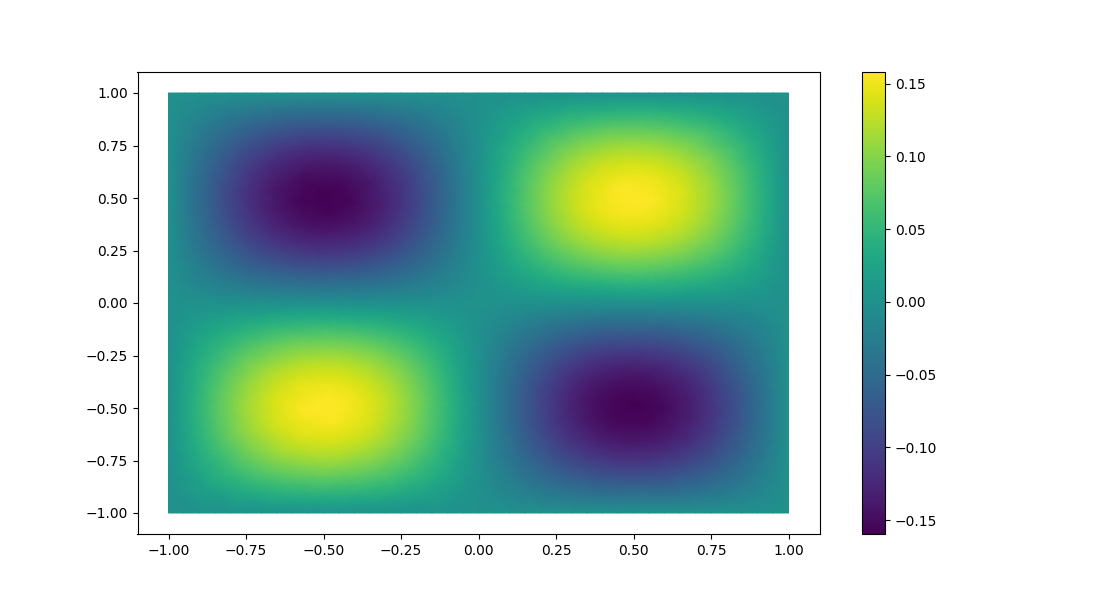

In [65]:
plot_fn(u)

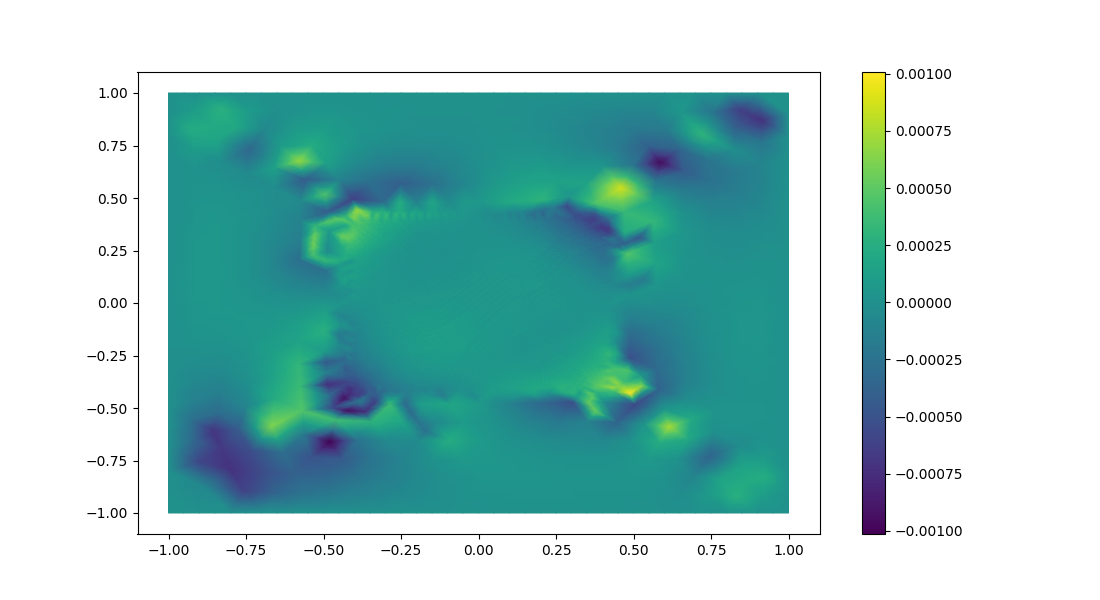

In [66]:
plot_fn(error)